In [79]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Attention Mechanisms
In this exercise we will write a attention mechanism to solve the following problem

"Given a length 10 sequence of integers, are there more '2s' than '4s' ?"

This could of course be easily handled by a fully connected network, but we'll force the network
to learn this by learning to place attention on the right values. I.e. the strategy is

* embed the individual integer into a high-dimensional vector (using torch.nn.Embedding)
* once we have those embeddings compute how much attention to place on each vector by comparing "key" values computed from the embedded values 
* compute "answer" values to our query by weighting the individual responsed by their attention value


$$
v_{ik} = \mathrm{softmax}_\mathrm{keys}(\frac{q_{i}\cdot k_{j}}{\sqrt{d}}) v_{jk}
$$


## Preparation
Before we bring this all to live in a written class, we go through each step in order to understand it properly. 

We will use the QKV - Self Attention Encoding Part.
For doing so we will replicate the shown procedure:


<img src="Grafiken/text1.svg" alt="Attention">

### Generating Data
Write a data-generating function that produces a batch of N examples or length-10 sequences of random integers between 0 and 9 as well as a binary label indicating whether the sequence has more 2s than 4s. The output should return (X,y), where X has shape `(N,10)` and y has shape `(N,1)`

```python
def make_batch(N):
    ...
```

In [96]:
def make_batch(N):
    t = torch.randint(0,9, size=(N,10))
    more_twos_than_fours = torch.FloatTensor([len(x[x==2]) > len(x[x==4]) for x in t])

    return t, more_twos_than_fours.reshape(-1,1)


### Embedding the Integers
Deep Learning works well in higher dimensions. So we'll embed the 10 possible integers into a vector space using `torch.nn.Embedding`


* Verify that using e.g. a module like `torch.nn.Embedding(10,embed_dim)` achieves this
* Take a random vector of integers of shape (N,M) and evaluate them through an embedding module
* Does the output dimension make sense?


In [81]:
x, y = make_batch(5)

In [82]:
embed_dim = 15

embed = torch.nn.Embedding(10, embed_dim)
embedded = embed(x)

### Extracting Keys and Values 

Once data is embedded we can extract keys and values by a linear projection

* For 2 linear layers `torch.nn.Linear(embed_dim,att_dim)` we can extract keys and values for the output of the previous step
* verify that this works from a shape perspective

In [83]:
att_dim = 64

In [84]:
key_proj = torch.nn.Linear(embed_dim, att_dim)
val_proj = torch.nn.Linear(embed_dim, att_dim)

In [85]:
key_proj(embedded).shape , val_proj(embedded).shape 

(torch.Size([5, 10, 64]), torch.Size([5, 10, 64]))

## Computing Attention
<img src="Grafiken/text1.svg" alt="Attention">
Implement the Attention-formula from above in a batched manner, such that for a input set of sequences `(N,10)`
you get an output set of attention-weighted values `(N,1)`

* It's easiest when using the function `torch.einsum` which uses the Einstein summation you may be familiar with from special relativity
* e.g. a "batched" dot product is performed using `einsum('bik,bjk->bij')` where `b` indicates the batch index, `i` and `j` are position indices and `k` are the coordinates of the vectors


--> **Some hints**
* Keep in mind that the dimension $\sqrt{d}$in the softmax function is your `att_dim`
* Initiate your query randomly in the size `1,att_dim`
* query and keys: einsum --> `'ik,bjk->bij'`
* for the softmax use `dim=-1`

In [86]:
query = torch.randn(1,att_dim)
keys = key_proj(embedded)
values = val_proj(embedded)

In [87]:
qk = torch.einsum('ik,bjk->bij',query,keys)
att = torch.softmax(qk/att_dim**0.5 , dim=-1)

aggreg = torch.einsum('bij,bjk->bik',att,values)

# Integrate into a Module

Complete the following torch Module:

To use the `self.nn` make sure to have an input shaped like `torch.Size([batch, att_dim])`

* For the `forward(x)` function have a look at the Graph in 1.2 again and follow along
```python
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        # compute attention
        ...
    
    def values(self,x):
        # compute values
        ...
                
    def forward(self,x):
        # compute final classification using attention, values and final NN
      
```

In [88]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij',queries,keys)
        att = torch.softmax(qk/(self.att_dim**0.5),dim=-1)
        return att
    
    def values(self,x):
        return self.WV(x)

                
    def forward(self,x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik',att,values)
        mlp_result = self.nn(aggreg[:,0,:])
        return mlp_result

## Predefine Plot Function
Use this given function later on to visualize your training. 
Just execute the following cell.

In [89]:
def plot(model,N,traj):
    x,y = make_batch(N)
    f,axarr = plt.subplots(1,3)
    f.set_size_inches(10,2)
    ax = axarr[0]
    at = model.attention(model.embed(x))[:,0,:].detach().numpy()
    ax.imshow(at)
    ax = axarr[1]
    
    
    vals = model.values(model.embed(x))[:,:,0].detach().numpy()
    nan = np.ones_like(vals)*np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan,vmin = -1, vmax = 1)
    for i,xx in enumerate(x):
        for j,xxx in enumerate(xx):
            ax = axarr[0]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
            ax = axarr[1]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
    ax = axarr[2]
    ax.plot(traj)
    f.set_tight_layout(True)


## Train the Model

In [94]:
def train():
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(),lr = 1e-4)

    traj = []
    for i in range(5001):
        x,y = make_batch(100)
        p = model.forward(x)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        traj.append(float(loss))
        if i % 500 == 0:
            plot(model,5,traj)
            plt.savefig('attention_{}.png'.format(str(i).zfill(6)))
            plt.show()
            print(i,loss)
        opt.step()
        opt.zero_grad()
    return traj


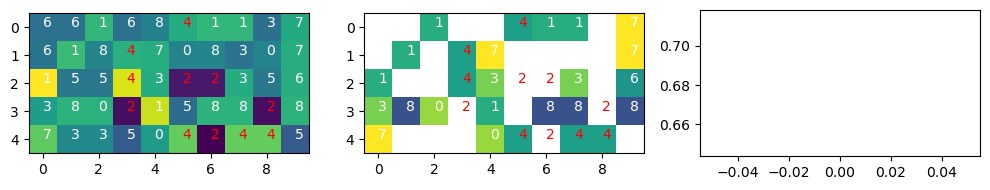

0 tensor(0.6810, grad_fn=<BinaryCrossEntropyBackward0>)


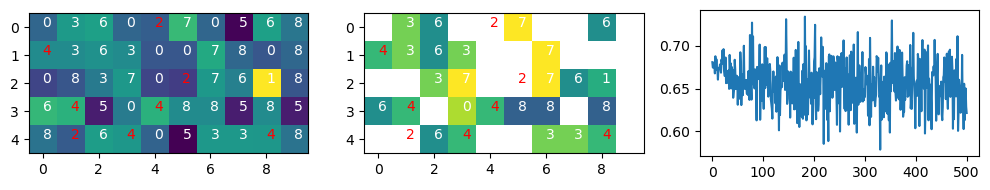

500 tensor(0.6213, grad_fn=<BinaryCrossEntropyBackward0>)


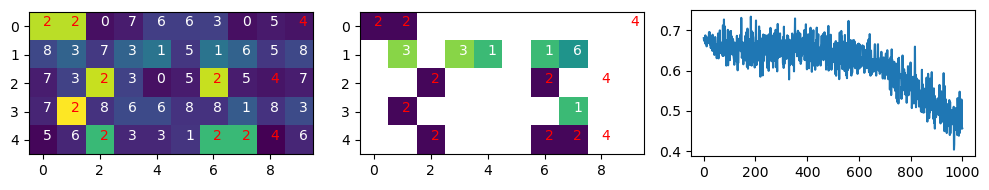

1000 tensor(0.4569, grad_fn=<BinaryCrossEntropyBackward0>)


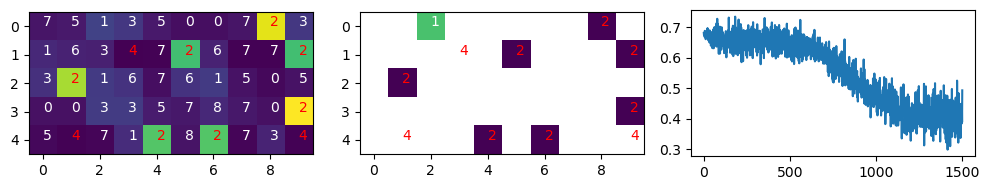

1500 tensor(0.4928, grad_fn=<BinaryCrossEntropyBackward0>)


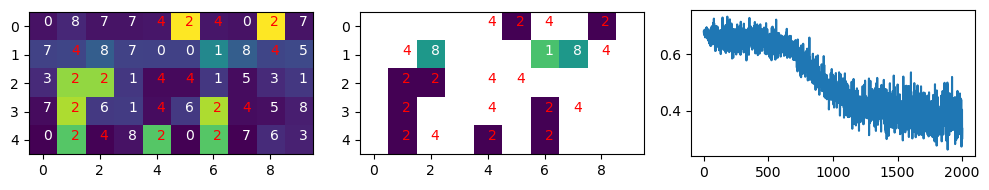

2000 tensor(0.3350, grad_fn=<BinaryCrossEntropyBackward0>)


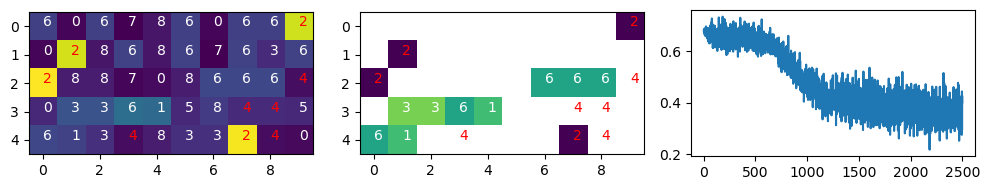

2500 tensor(0.4013, grad_fn=<BinaryCrossEntropyBackward0>)


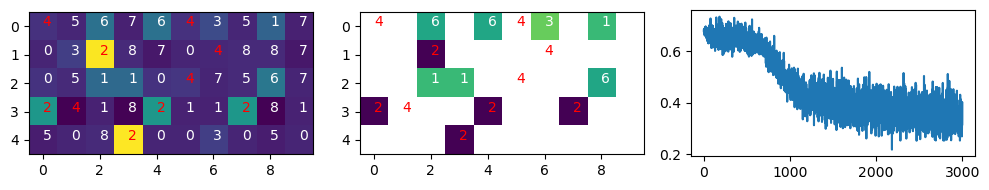

3000 tensor(0.3159, grad_fn=<BinaryCrossEntropyBackward0>)


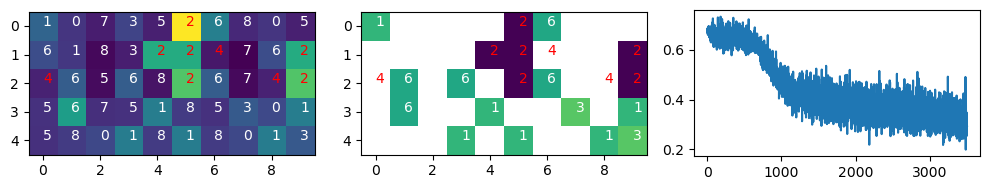

3500 tensor(0.2941, grad_fn=<BinaryCrossEntropyBackward0>)


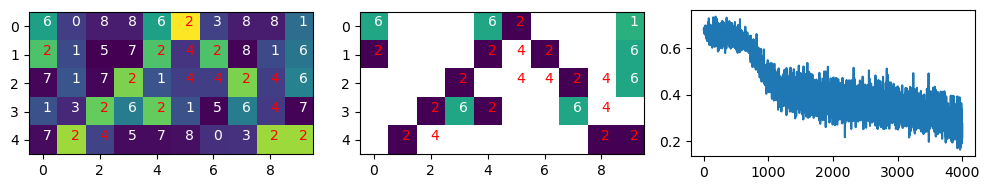

4000 tensor(0.2740, grad_fn=<BinaryCrossEntropyBackward0>)


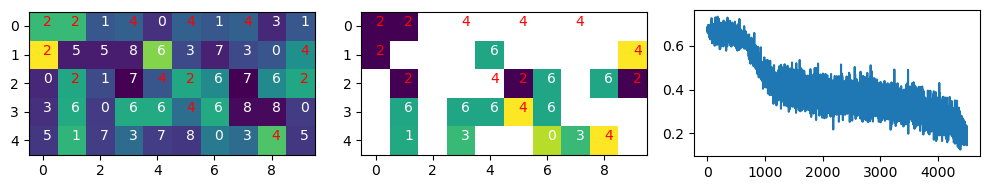

4500 tensor(0.2002, grad_fn=<BinaryCrossEntropyBackward0>)


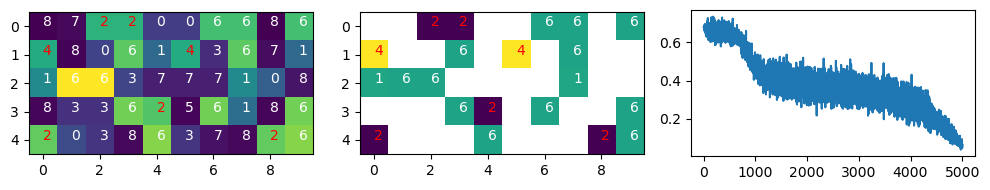

5000 tensor(0.0648, grad_fn=<BinaryCrossEntropyBackward0>)


In [97]:
training = train()

# Bonus
Maybe you want to change our rule to learn. 
You can play around how to properly choose the hyperparameters, such like`embed_dim`, `att_dim` and number of training steps in order to learn more complicated rules such like:  
`torch.FloatTensor([1 if (len(x[x==2]) > len(x[x==4])) or (len(x[x==5]) == len(x[x==8])) else 0 for x in t])`